In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('stocks.csv')
df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000
...,...,...,...,...,...,...,...,...
243,GOOG,2023-05-01,107.720001,108.680000,107.500000,107.709999,107.709999,20926300
244,GOOG,2023-05-02,107.660004,107.730003,104.500000,105.980003,105.980003,20343100
245,GOOG,2023-05-03,106.220001,108.129997,105.620003,106.120003,106.120003,17116300
246,GOOG,2023-05-04,106.160004,106.300003,104.699997,105.209999,105.209999,19780600


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,215.252093,217.919662,212.697452,215.381674,215.362697,3.208210e+07
std,91.691315,92.863023,90.147881,91.461989,91.454750,2.233590e+07
min,89.540001,90.129997,88.860001,89.349998,89.349998,2.657900e+06
25%,135.235004,137.440004,134.822495,136.347498,136.347498,1.714180e+07
50%,208.764999,212.614998,208.184998,209.920006,209.920006,2.734000e+07
75%,304.177505,307.565002,295.437500,303.942505,303.942505,4.771772e+07
max,372.410004,373.829987,361.739990,366.829987,366.829987,1.133164e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB


In [5]:
df.isna().sum()

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df['Ticker'].unique()

array(['AAPL', 'MSFT', 'NFLX', 'GOOG'], dtype=object)

In [7]:
df.corr(numeric_only=True)

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999626,0.999650,0.999176,0.999173,-0.547741
High,0.999626,1.000000,0.999654,0.999644,0.999640,-0.546175
Low,0.999650,0.999654,1.000000,0.999663,0.999661,-0.544590
Close,0.999176,0.999644,0.999663,1.000000,0.999999,-0.544194
Adj Close,0.999173,0.999640,0.999661,0.999999,1.000000,-0.544370
Volume,-0.547741,-0.546175,-0.544590,-0.544194,-0.544370,1.000000


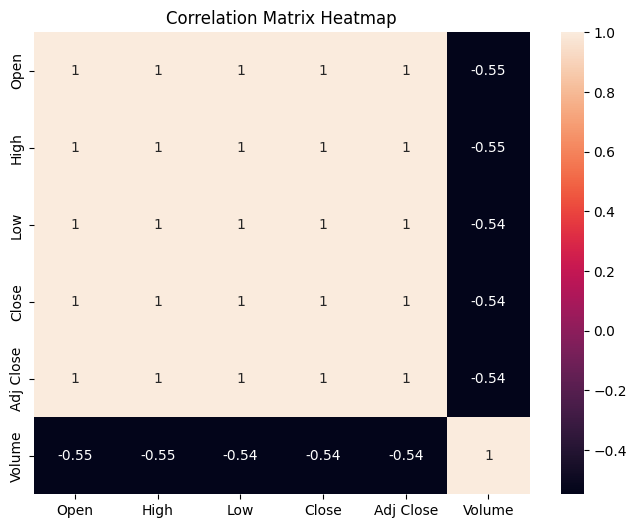

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

Unique Tickers: ['AAPL' 'MSFT' 'NFLX' 'GOOG']


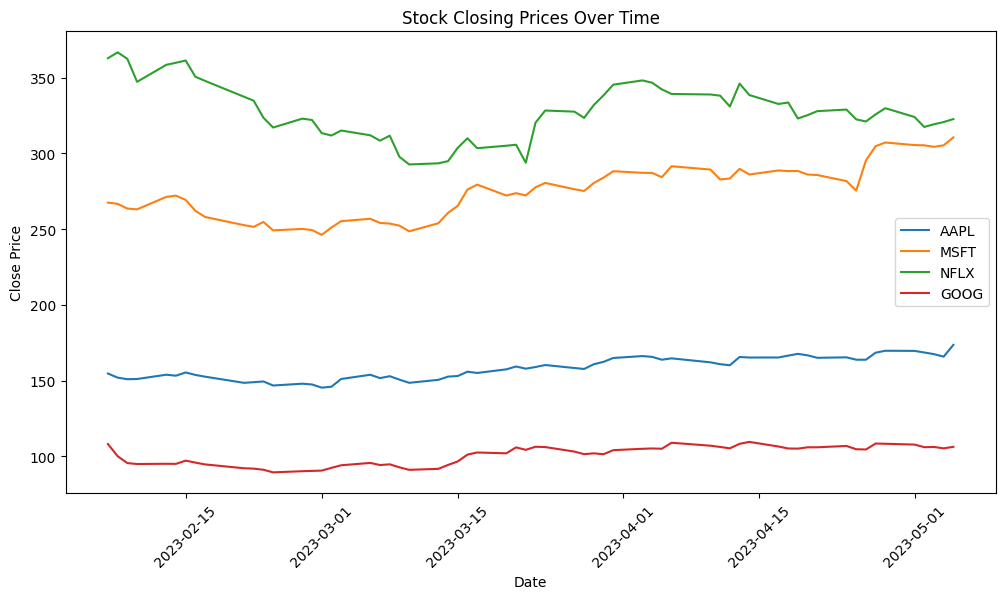

In [10]:
tickers = df['Ticker'].unique()
print("Unique Tickers:", tickers)

# Plot closing price for each ticker
plt.figure(figsize=(12, 6))
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close'], label=ticker)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Closing Prices Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

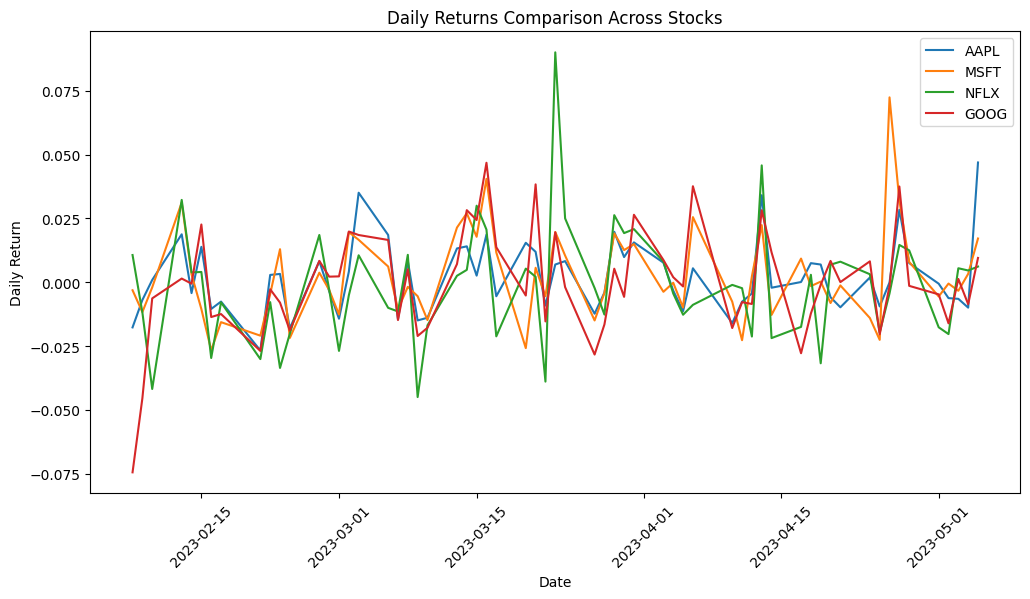

In [11]:
# Compute daily returns for each ticker
df['Daily Return'] = df.groupby('Ticker')['Close'].pct_change()

# Plot daily returns for each ticker
plt.figure(figsize=(12, 6))
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Daily Return'], label=ticker)

plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Returns Comparison Across Stocks")
plt.xticks(rotation=45)
plt.legend()
plt.show()

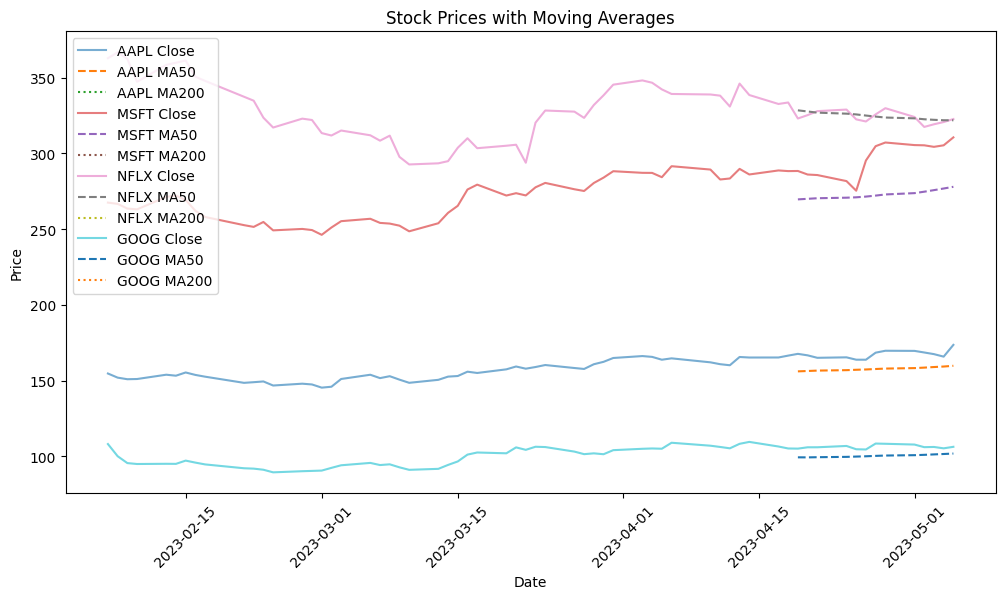

In [12]:
# Moving Averages (50-day and 200-day)
df['MA50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50).mean())
df['MA200'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=200).mean())

# Plot Moving Averages
plt.figure(figsize=(12, 6))
for ticker in tickers:
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close'], label=f"{ticker} Close", alpha=0.6)
    plt.plot(subset['Date'], subset['MA50'], label=f"{ticker} MA50", linestyle='dashed')
    plt.plot(subset['Date'], subset['MA200'], label=f"{ticker} MA200", linestyle='dotted')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Prices with Moving Averages")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [13]:
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA50,MA200
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,NaN,NaN,NaN
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,-0.017653,NaN,NaN
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100,-0.006912,NaN,NaN
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700,0.000928,NaN,NaN
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000,0.018807,NaN,NaN


In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year-Month'] = df['Date'].dt.to_period('M')

In [15]:
monthly_avg = df.groupby(['Ticker', 'Year-Month'])['Close'].mean().reset_index()
monthly_avg['Year-Month'] = monthly_avg['Year-Month'].astype(str)
monthly_avg['Year-Month'] = pd.to_datetime(monthly_avg['Year-Month'])

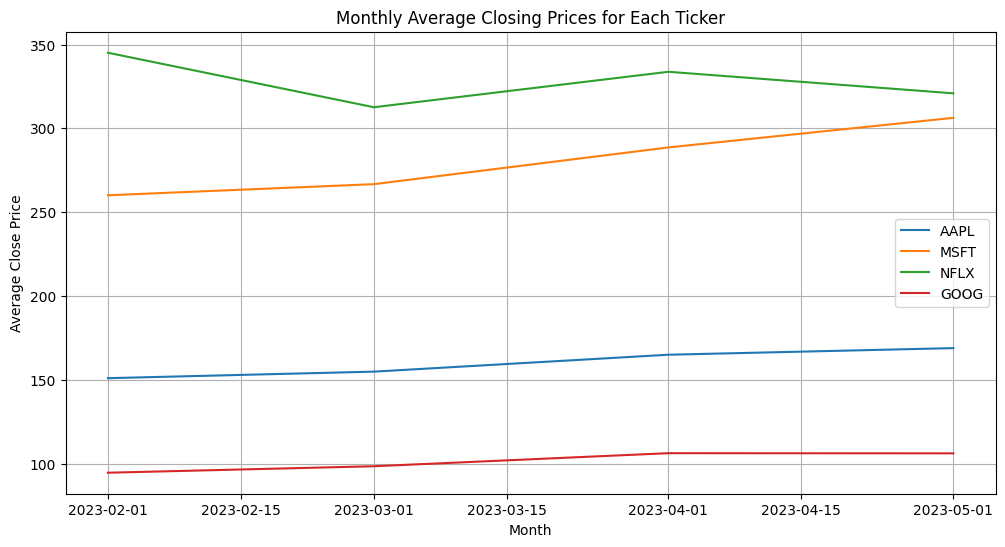

In [16]:
# Plot Monthly Closing Prices for each Ticker
plt.figure(figsize=(12, 6))
for ticker in df['Ticker'].unique():
    subset = monthly_avg[monthly_avg['Ticker'] == ticker]
    plt.plot(subset['Year-Month'], subset['Close'], label=ticker)

plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.title("Monthly Average Closing Prices for Each Ticker")
plt.grid()
plt.legend()

In [17]:
## Convert Raw Date to Year, Month and Week
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week 

In [18]:
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA50,MA200,Year-Month,Year,Month,Week
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,NaN,NaN,NaN,2023-02,2023,2,6
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,-0.017653,NaN,NaN,2023-02,2023,2,6
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100,-0.006912,NaN,NaN,2023-02,2023,2,6
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700,0.000928,NaN,NaN,2023-02,2023,2,6
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000,0.018807,NaN,NaN,2023-02,2023,2,7


In [19]:
df.set_index(keys=['Date'], inplace=True)

In [20]:
df.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA50,MA200,Year-Month,Year,Month,Week
Date,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,NaN,NaN,NaN,2023-02,2023,2,6
2023-02-08,AAPL,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,-0.017653,NaN,NaN,2023-02,2023,2,6
2023-02-09,AAPL,153.779999,154.330002,150.419998,150.869995,150.639999,56007100,-0.006912,NaN,NaN,2023-02,2023,2,6
2023-02-10,AAPL,149.460007,151.339996,149.220001,151.009995,151.009995,57450700,0.000928,NaN,NaN,2023-02,2023,2,6
2023-02-13,AAPL,150.949997,154.259995,150.919998,153.850006,153.850006,62199000,0.018807,NaN,NaN,2023-02,2023,2,7


In [21]:
df_stock=df[['Ticker', 'Open', 'High', 'Low', 'Close']].copy()

In [22]:
df_stock

,Ticker,Open,High,Low,Close
Date,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994
2023-02-08,AAPL,153.880005,154.580002,151.169998,151.919998
2023-02-09,AAPL,153.779999,154.330002,150.419998,150.869995
2023-02-10,AAPL,149.460007,151.339996,149.220001,151.009995
2023-02-13,AAPL,150.949997,154.259995,150.919998,153.850006
...,...,...,...,...,...
2023-05-01,GOOG,107.720001,108.680000,107.500000,107.709999
2023-05-02,GOOG,107.660004,107.730003,104.500000,105.980003
2023-05-03,GOOG,106.220001,108.129997,105.620003,106.120003


---
## 🍀AAPL

### 🍁ETS of AAPL

In [23]:
ticker = 'AAPL'
ts = df[df['Ticker'] == ticker]['Close']

In [24]:
adf_test = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Check stationarity
if adf_test[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -0.291692905959482
p-value: 0.9266726529518907
Time series is NOT stationary. Differencing may be needed.


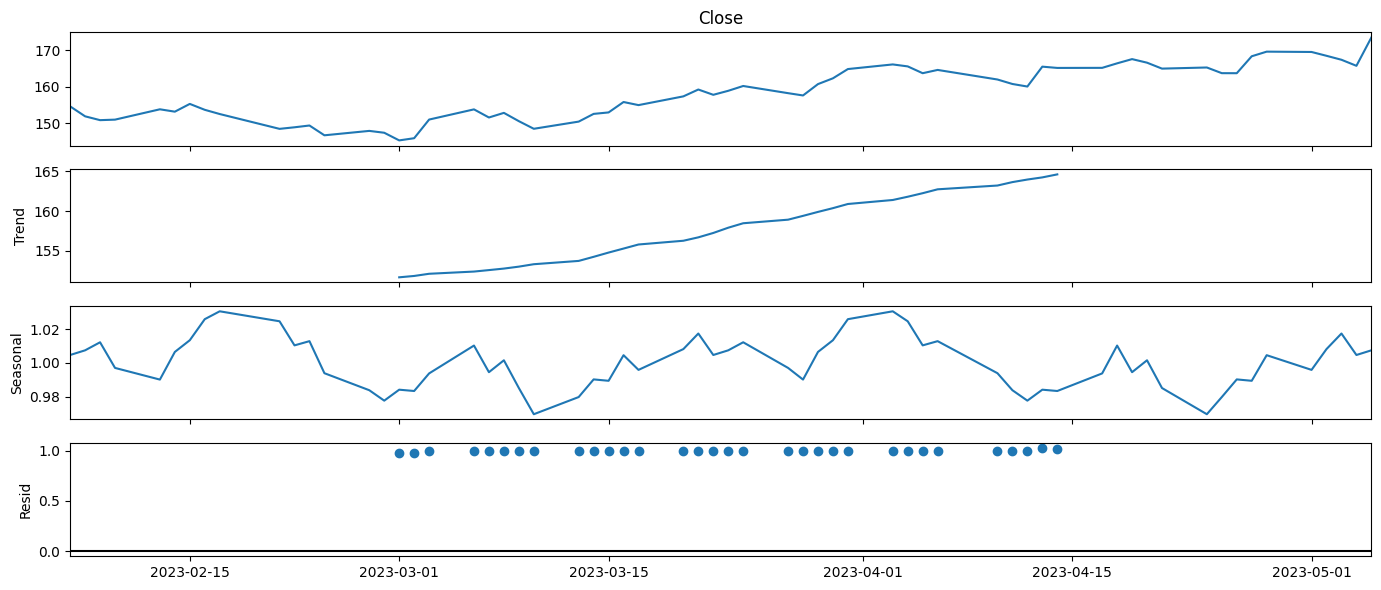

In [25]:
decomposition=seasonal_decompose(ts, model='multiplicative', period=30)
rcParams['figure.figsize'] = 14,6
decomposition.plot()
plt.show()

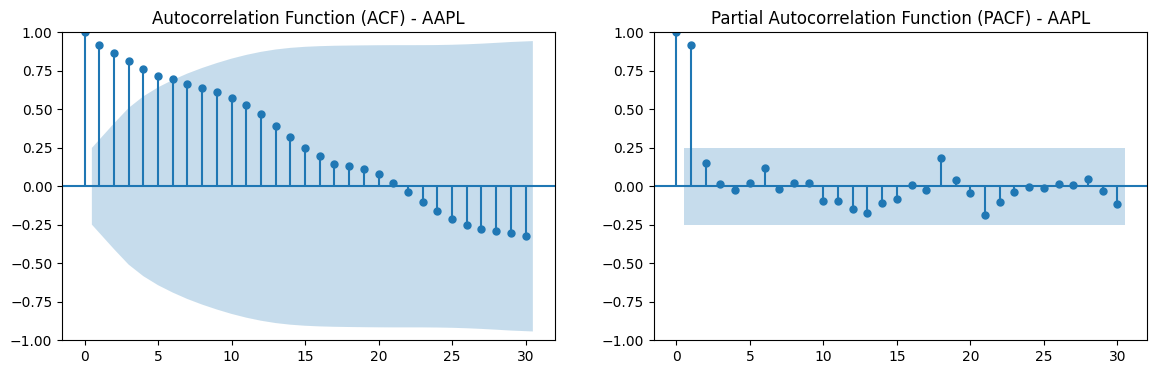

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), ax=ax[0], lags=30)  # Show up to 30 lags
ax[0].set_title(f"Autocorrelation Function (ACF) - {ticker}")

plot_pacf(ts.dropna(), ax=ax[1], lags=30, method="ywm")  # Use "ywm" method for better estimation
ax[1].set_title(f"Partial Autocorrelation Function (PACF) - {ticker}")

plt.show()

### 🍁ARIMA (AAPL)

In [27]:
auto_arima_model = auto_arima(ts, seasonal=False, stepwise=True, trace=True)
print(f"Optimal ARIMA order: {auto_arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=273.936, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=275.934, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=275.933, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=273.124, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.910 seconds
Optimal ARIMA order: (0, 1, 0)


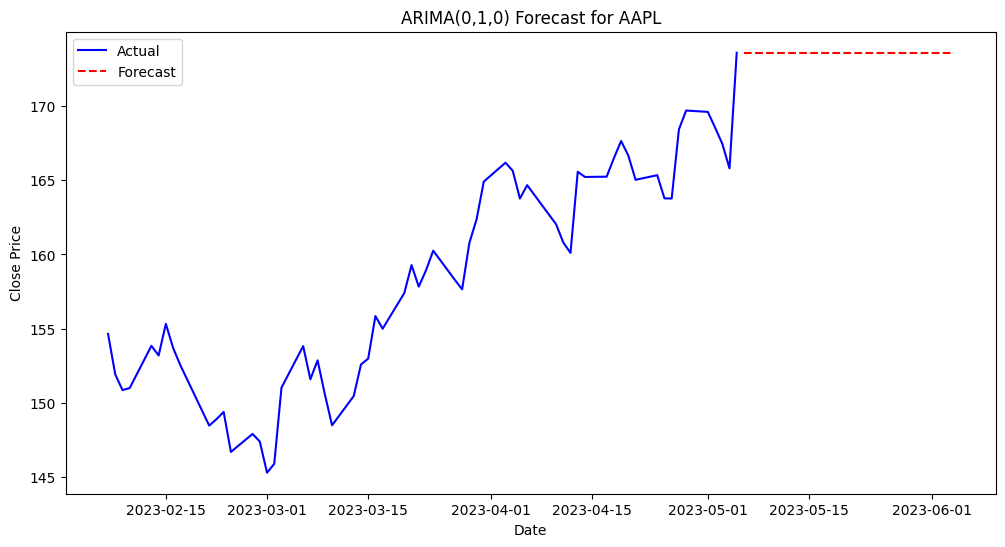

In [28]:
model = ARIMA(ts, order=(0, 1, 0))
result = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

# Create date range for forecasted values
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Actual", color="blue")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="dashed", color="red")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"ARIMA(0,1,0) Forecast for {ticker}")
plt.legend()
plt.show()

---
## 🍀MSFT

### 🍁ETS of MSFT

In [29]:
ticker = 'MSFT'
ts = df[df['Ticker'] == ticker]['Close']

In [30]:
adf_test = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Check stationarity
if adf_test[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -0.14980707695390777
p-value: 0.944245989051481
Time series is NOT stationary. Differencing may be needed.


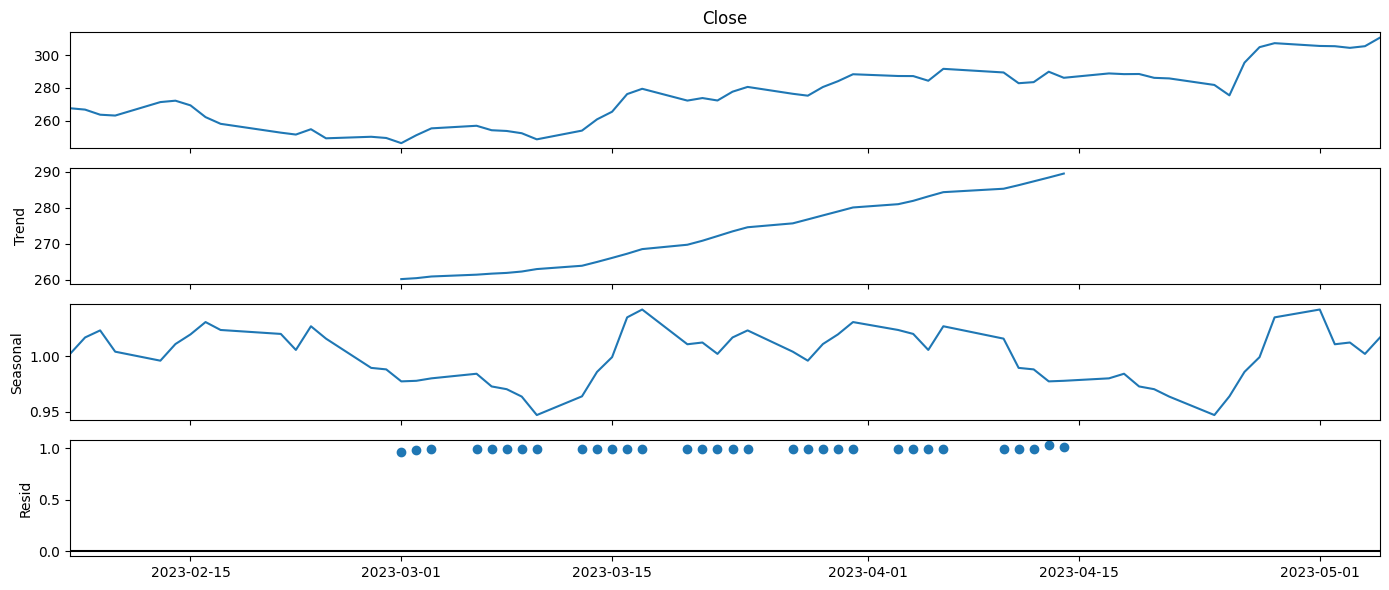

In [31]:
decomposition=seasonal_decompose(ts, model='multiplicative', period=30)
rcParams['figure.figsize'] = 14,6
decomposition.plot()
plt.show()

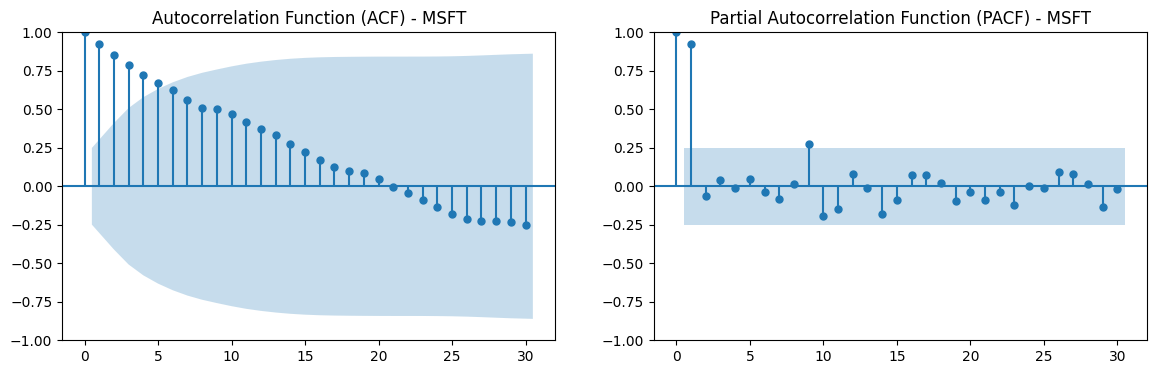

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), ax=ax[0], lags=30)  # Show up to 30 lags
ax[0].set_title(f"Autocorrelation Function (ACF) - {ticker}")

plot_pacf(ts.dropna(), ax=ax[1], lags=30, method="ywm")  # Use "ywm" method for better estimation
ax[1].set_title(f"Partial Autocorrelation Function (PACF) - {ticker}")

plt.show()

### 🍁ARIMA (MSFT)

In [33]:
auto_arima_model = auto_arima(ts, seasonal=False, stepwise=True, trace=True)
print(f"Optimal ARIMA order: {auto_arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=373.244, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=369.474, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=370.010, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=369.324, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=368.760, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=370.591, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.057 seconds
Optimal ARIMA order: (0, 1, 0)


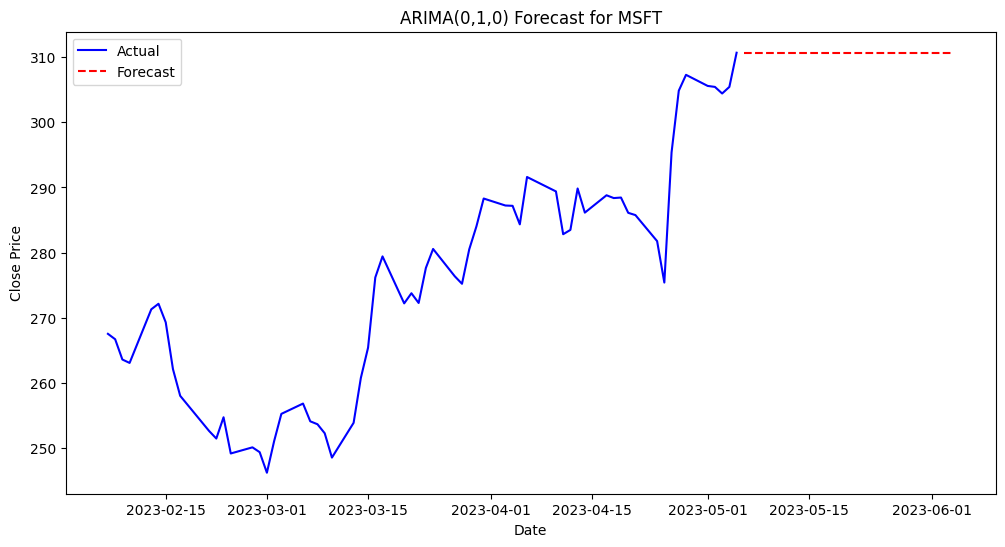

In [34]:
model = ARIMA(ts, order=(0, 1, 0))
result = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

# Create date range for forecasted values
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Actual", color="blue")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="dashed", color="red")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"ARIMA(0,1,0) Forecast for {ticker}")
plt.legend()
plt.show()

---
## 🍀NFLX

### 🍁ETS of NFLX

In [35]:
ticker = 'NFLX'
ts = df[df['Ticker'] == ticker]['Close']

In [36]:
adf_test = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Check stationarity
if adf_test[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -2.150926443901294
p-value: 0.2245356394880873
Time series is NOT stationary. Differencing may be needed.


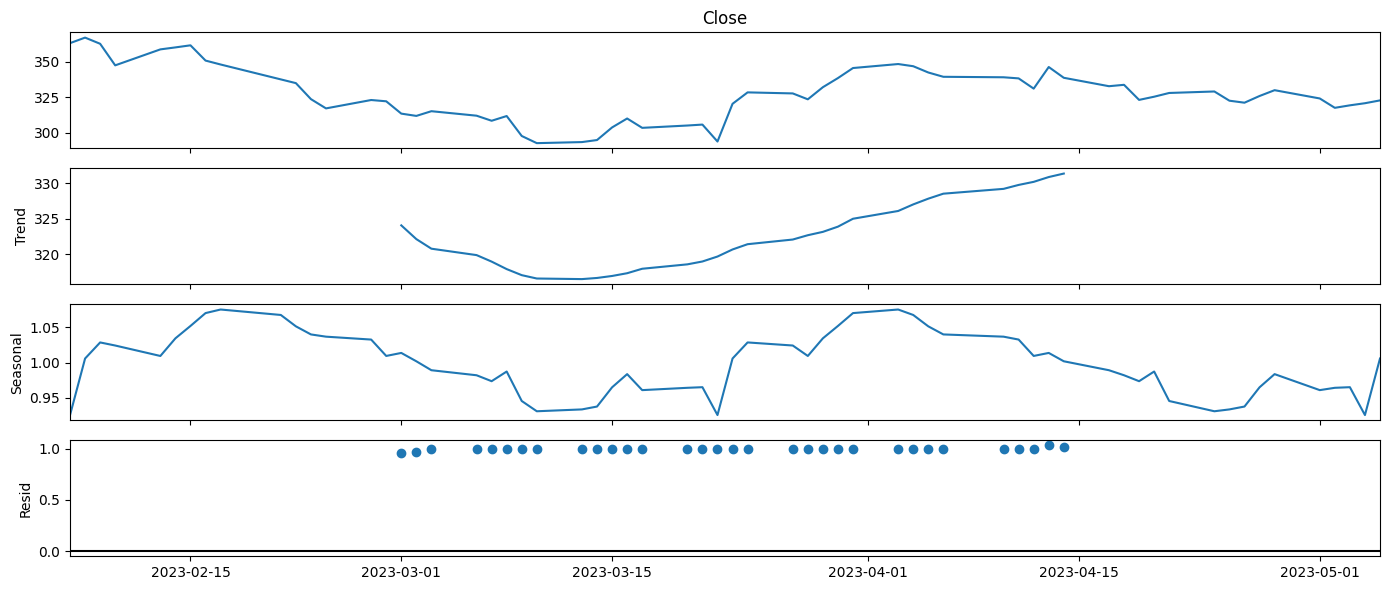

In [37]:
decomposition=seasonal_decompose(ts, model='multiplicative', period=30)
rcParams['figure.figsize'] = 14,6
decomposition.plot()
plt.show()

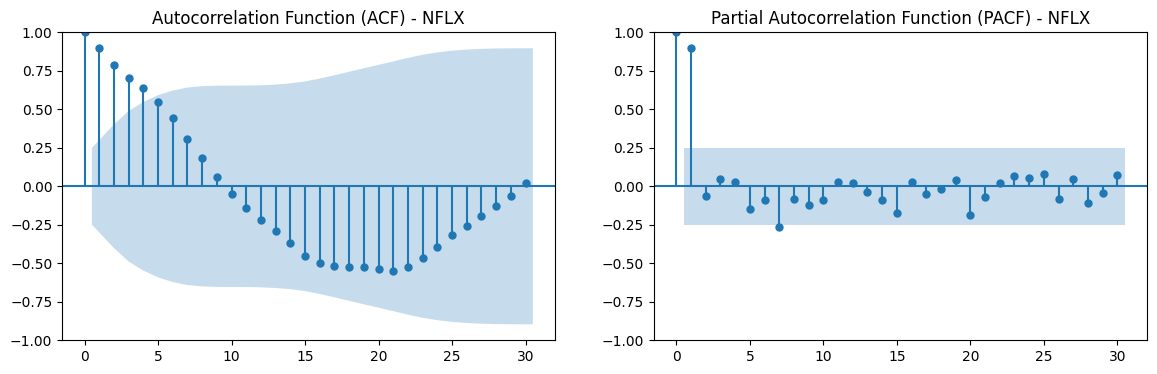

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), ax=ax[0], lags=30)  # Show up to 30 lags
ax[0].set_title(f"Autocorrelation Function (ACF) - {ticker}")

plot_pacf(ts.dropna(), ax=ax[1], lags=30, method="ywm")  # Use "ywm" method for better estimation
ax[1].set_title(f"Partial Autocorrelation Function (PACF) - {ticker}")

plt.show()

### 🍁ARIMA (NFLX)

In [39]:
auto_arima_model = auto_arima(ts, seasonal=False, stepwise=True, trace=True)
print(f"Optimal ARIMA order: {auto_arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=896.332, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=433.897, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=435.420, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=428.412, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=489.369, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=426.412, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=541.108, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=428.412, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=430.300, Time=0.41 sec

Best 

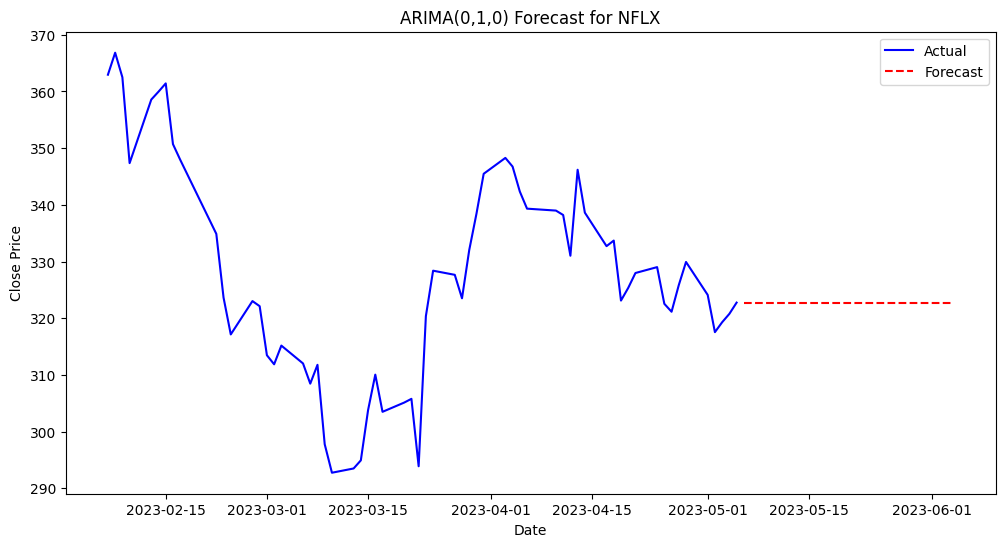

In [40]:
model = ARIMA(ts, order=(0, 1, 0))
result = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

# Create date range for forecasted values
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Actual", color="blue")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="dashed", color="red")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"ARIMA(0,1,0) Forecast for {ticker}")
plt.legend()
plt.show()

---
## 🍀GOOG

### 🍁ETS of GOOG

In [41]:
ticker = 'GOOG'
ts = df[df['Ticker'] == ticker]['Close']

In [42]:
adf_test = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Check stationarity
if adf_test[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -1.4315041927599246
p-value: 0.567082932275287
Time series is NOT stationary. Differencing may be needed.


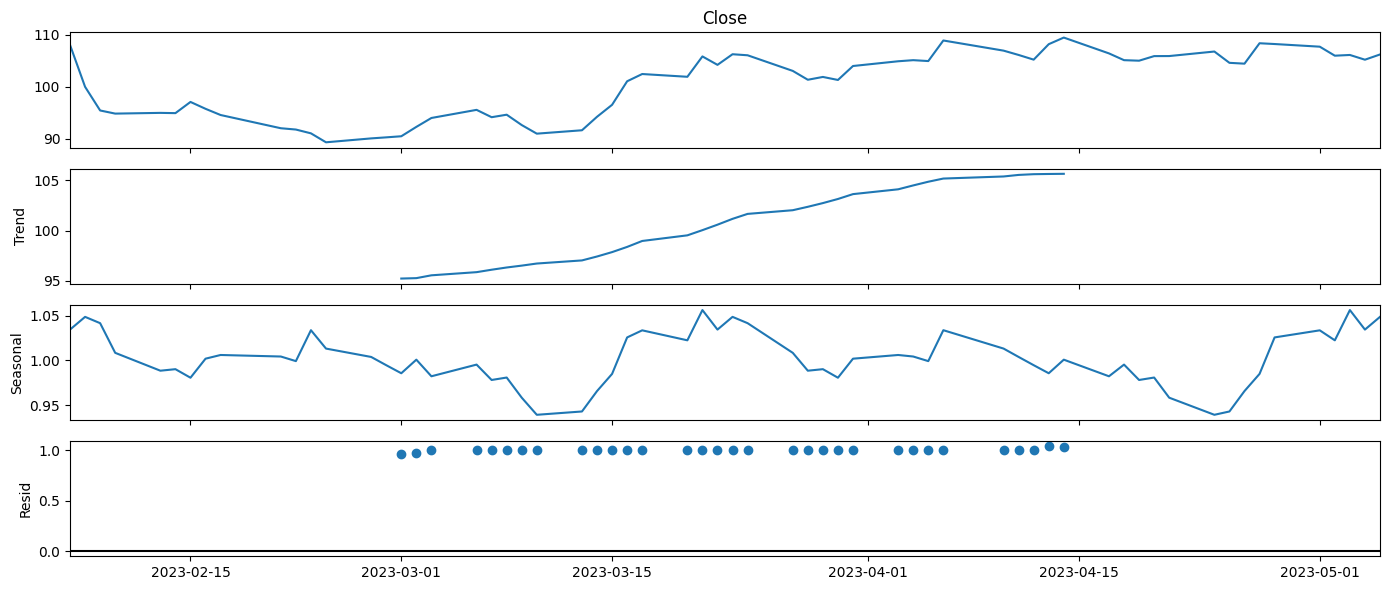

In [43]:
decomposition=seasonal_decompose(ts, model='multiplicative', period=30)
rcParams['figure.figsize'] = 14,6
decomposition.plot()
plt.show()

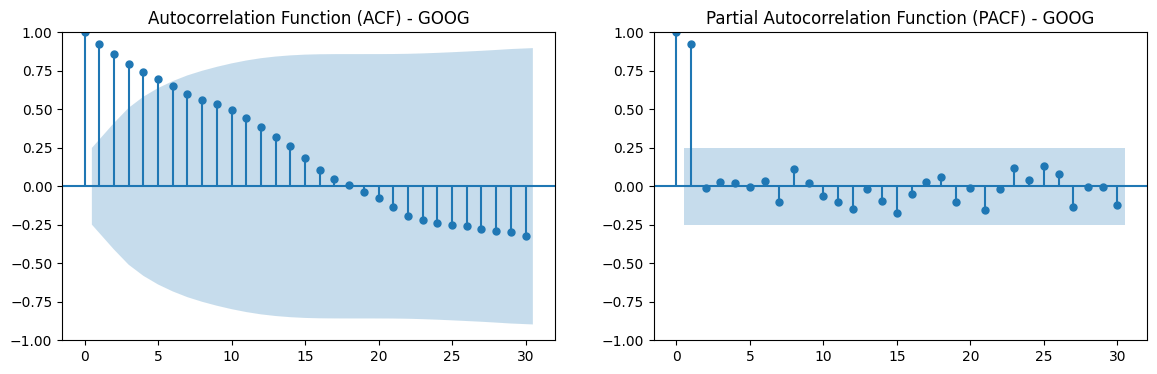

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), ax=ax[0], lags=30)  # Show up to 30 lags
ax[0].set_title(f"Autocorrelation Function (ACF) - {ticker}")

plot_pacf(ts.dropna(), ax=ax[1], lags=30, method="ywm")  # Use "ywm" method for better estimation
ax[1].set_title(f"Partial Autocorrelation Function (PACF) - {ticker}")

plt.show()

### 🍁ARIMA (GOOG)

In [45]:
auto_arima_model = auto_arima(ts, seasonal=False, stepwise=True, trace=True)
print(f"Optimal ARIMA order: {auto_arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=267.474, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=265.982, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=266.268, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=265.486, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=267.982, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.140 seconds
Optimal ARIMA order: (0, 1, 0)


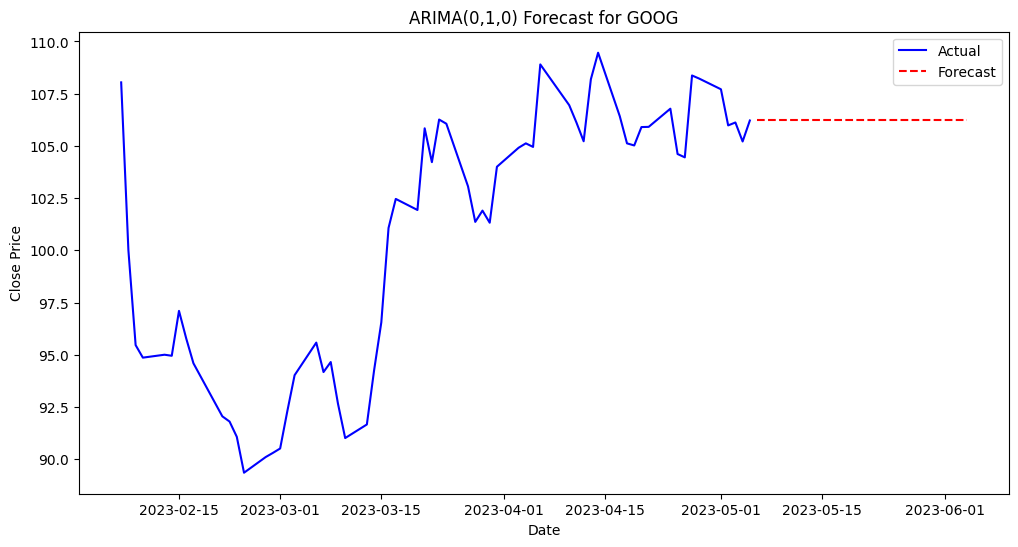

In [46]:
model = ARIMA(ts, order=(0, 1, 0))
result = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

# Create date range for forecasted values
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Actual", color="blue")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="dashed", color="red")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"ARIMA(0,1,0) Forecast for {ticker}")
plt.legend()
plt.show()